In [43]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 4 # batch size for training and evaluation

In [2]:
!pip install pytorchvideo transformers evaluate -q

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

In [5]:
!tar xf {file_path}

In [6]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -5

UCF101_subset
UCF101_subset/train
UCF101_subset/train/BalanceBeam
UCF101_subset/train/BalanceBeam/v_BalanceBeam_g10_c04.avi
UCF101_subset/train/BalanceBeam/UCF101


In [7]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [8]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [9]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g10_c04.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g14_c03.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g25_c01.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g23_c04.avi'),
 PosixPath('UCF101_subset/train/BalanceBeam/v_BalanceBeam_g07_c02.avi')]

In [10]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


In [18]:
from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification


feature_extractor = VideoMAEFeatureExtractor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.8/dist-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at MCG-NJU/videomae-base were not used when initializing VideoMAEForVideoClassification: ['decoder.decoder_layers.1.attention.attention.v_bias', 'mask_token', 'decoder.decoder_layers.2.layernorm_after.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.1.output.dense.bias', 'decoder.decoder_layers.3.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.attention.v_bias', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.3.output.dense.weight', 'decoder.decoder_layers.3.layernorm_after.bias', 'decoder.decoder_layers.1.layernorm_after.bias', 'decoder.decoder_layers.3.attention.attention.q_bias', 'decoder.

In [19]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [21]:
feature_extractor.size

{'shortest_edge': 224}

In [28]:
feature_extractor.size['shortest_edge']

224

In [29]:
import os

mean = feature_extractor.image_mean
std = feature_extractor.image_std
#resize_to = feature_extractor.size
resize_to = feature_extractor.size['shortest_edge']

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)
# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize((resize_to, resize_to)),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [30]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [31]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [32]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


In [33]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

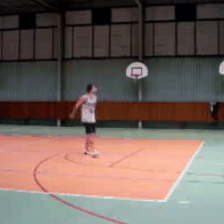

In [34]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [48]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 2

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
import evaluate

metric = evaluate.load("accuracy")

In [37]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [38]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [49]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/content/videomae-base-finetuned-ucf101-subset is already a clone of https://huggingface.co/minoosh/videomae-base-finetuned-ucf101-subset. Make sure you pull the latest changes with `repo.git_pull()`.
max_steps is given, it will override any value given in num_train_epochs


In [50]:
train_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 600
  Num Epochs = 9223372036854775807
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Number of trainable parameters = 86234890


Epoch,Training Loss,Validation Loss,Accuracy
0,1.587800,1.522667,0.414286
1,0.568600,0.896302,0.628571


***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 4
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-75
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-75/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-75/pytorch_model.bin
Image processor saved in videomae-base-finetuned-ucf101-subset/checkpoint-75/preprocessor_config.json
Image processor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json
***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 4
Saving model checkpoint to videomae-base-finetuned-ucf101-subset/checkpoint-150
Configuration saved in videomae-base-finetuned-ucf101-subset/checkpoint-150/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/checkpoint-150/pytorch_model.bin
Image processor saved in videomae-base-finetuned-ucf101-subset/checkpoint-150/preprocessor_config.json
Image processor saved in videomae-base-fin

In [51]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples: Unknown
  Batch size = 4


{'eval_loss': 0.697290301322937,
 'eval_accuracy': 0.8535031847133758,
 'eval_runtime': 51.5885,
 'eval_samples_per_second': 3.043,
 'eval_steps_per_second': 0.775,
 'epoch': 1.5}

In [ ]:
'''trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()'''

## push to hub

In [52]:
trainer.push_to_hub()

Saving model checkpoint to videomae-base-finetuned-ucf101-subset
Configuration saved in videomae-base-finetuned-ucf101-subset/config.json
Model weights saved in videomae-base-finetuned-ucf101-subset/pytorch_model.bin
Image processor saved in videomae-base-finetuned-ucf101-subset/preprocessor_config.json


Upload file runs/Feb13_12-19-37_e3df64cb87fe/events.out.tfevents.1676290786.e3df64cb87fe.6025.3: 100%|########…

Upload file runs/Feb13_12-19-37_e3df64cb87fe/events.out.tfevents.1676291259.e3df64cb87fe.6025.5: 100%|########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/minoosh/videomae-base-finetuned-ucf101-subset
   b01cdda..37bc0df  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/minoosh/videomae-base-finetuned-ucf101-subset
   b01cdda..37bc0df  main -> main

To https://huggingface.co/minoosh/videomae-base-finetuned-ucf101-subset
   37bc0df..ec6a418  main -> main

   37bc0df..ec6a418  main -> main



'https://huggingface.co/minoosh/videomae-base-finetuned-ucf101-subset/commit/37bc0dff62c7e458ffcbe98489338c7875237191'

## Inference

In [53]:
trained_model = VideoMAEForVideoClassification.from_pretrained('minoosh/videomae-base-finetuned-ucf101-subset')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--minoosh--videomae-base-finetuned-ucf101-subset/snapshots/ec6a4183556894608162dbd99761329ba824e940/config.json
Model config VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "ApplyEyeMakeup",
    "1": "ApplyLipstick",
    "2": "Archery",
    "3": "BabyCrawling",
    "4": "BalanceBeam",
    "5": "BandMarching",
    "6": "BaseballPitch",
    "7": "Basketball",
    "8": "BasketballDunk",
    "9": "BenchPress"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ApplyEyeMakeup": 0,
    "ApplyLipstick": 1,
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--minoosh--videomae-base-finetuned-ucf101-subset/snapshots/ec6a4183556894608162dbd99761329ba824e940/pytorch_model.bin
All model checkpoint weights were used when initializing VideoMAEForVideoClassification.

All the weights of VideoMAEForVideoClassification were initialized from the model checkpoint at minoosh/videomae-base-finetuned-ucf101-subset.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VideoMAEForVideoClassification for predictions without further training.


In [54]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name v_BenchPress_g09_c04.avi
video_index 70
clip_index 0
aug_index 0
label 9
Video label: BenchPress


In [42]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [55]:
logits = run_inference(trained_model, sample_test_video["video"])

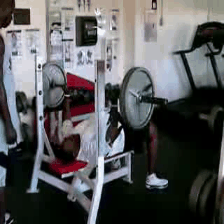

In [56]:
display_gif(sample_test_video["video"])

In [57]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BenchPress
